In [1]:
import os

try:
    snakemake
except NameError:
    from snakemk_util import load_rule_args
    
    os.chdir('../..')
    
    snakemake = load_rule_args(
        snakefile = os.getcwd() + "/workflow/Snakefile",
        rule_name = 'compare_lapa_polya_atlas',
        root = '..',
    )

In [2]:
import pandas as pd
import pyranges as pr
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
polya_atlas = list()

for i in snakemake.input['polya_atlas']:
    _df = pr.read_bed(i, as_df=True)
    _df = _df.rename(columns={'Score': 'tpm', 'ThickStart': 'usage', 
                              'ThickEnd': 'num_protocol', 'ItemRGB': 'tpm_ave', 
                              'BlockCount': 'annotation', 'BlockSizes': 'signal'})
    polya_atlas.append(_df)

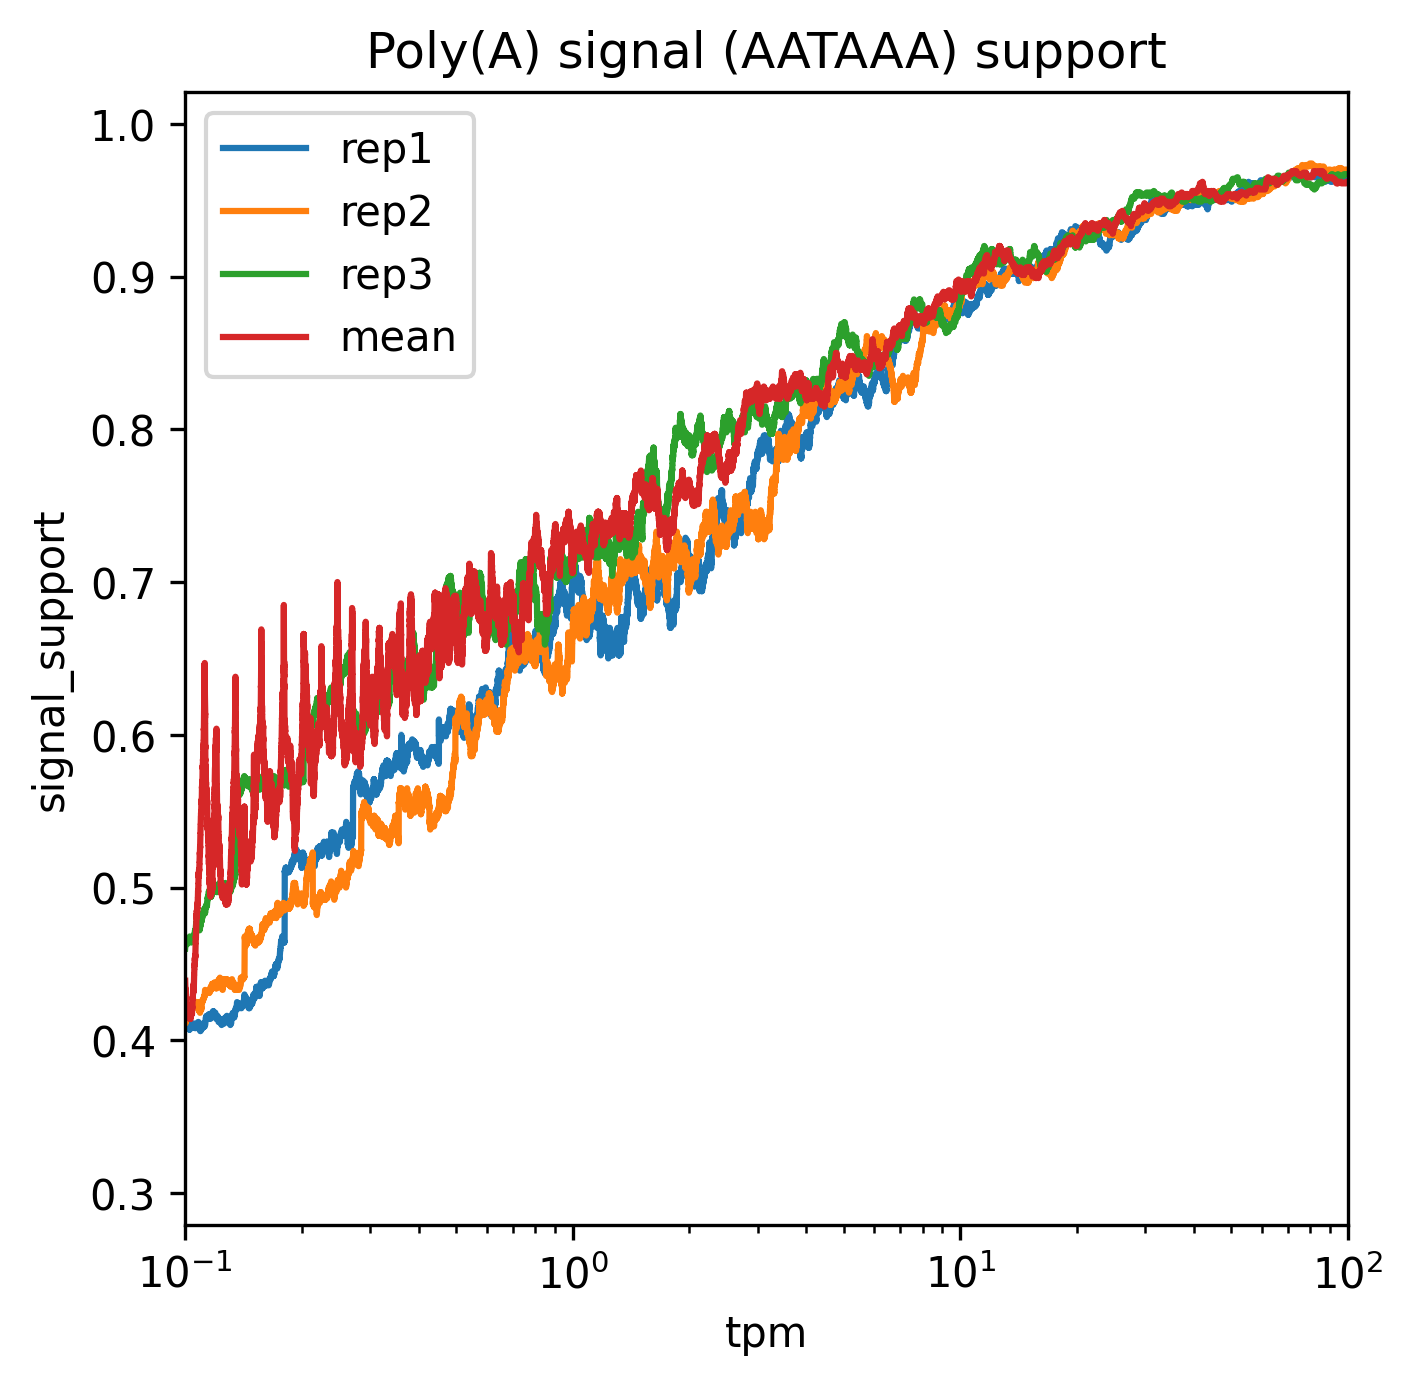

In [4]:
plt.figure(figsize=(5, 5), dpi=300)

for _df in polya_atlas:
    _df = _df.copy()
    _df['signal_support'] = ~_df.signal.isna()
    _df = _df[['signal_support', 'tpm']].sort_values('tpm').rolling(1000).mean()
    sns.lineplot(data=_df, x='tpm', y='signal_support')

_df = polya_atlas[0].copy()
_df['signal_support'] = ~_df.signal.isna()
_df = _df[['signal_support', 'tpm_ave']].sort_values('tpm_ave').rolling(1000).mean()
sns.lineplot(data=_df, x='tpm_ave', y='signal_support')

plt.xscale('log')
plt.xlim((0.1, 100))
plt.title('Poly(A) signal (AATAAA) support')
plt.legend(['rep1', 'rep2', 'rep3', 'mean'])

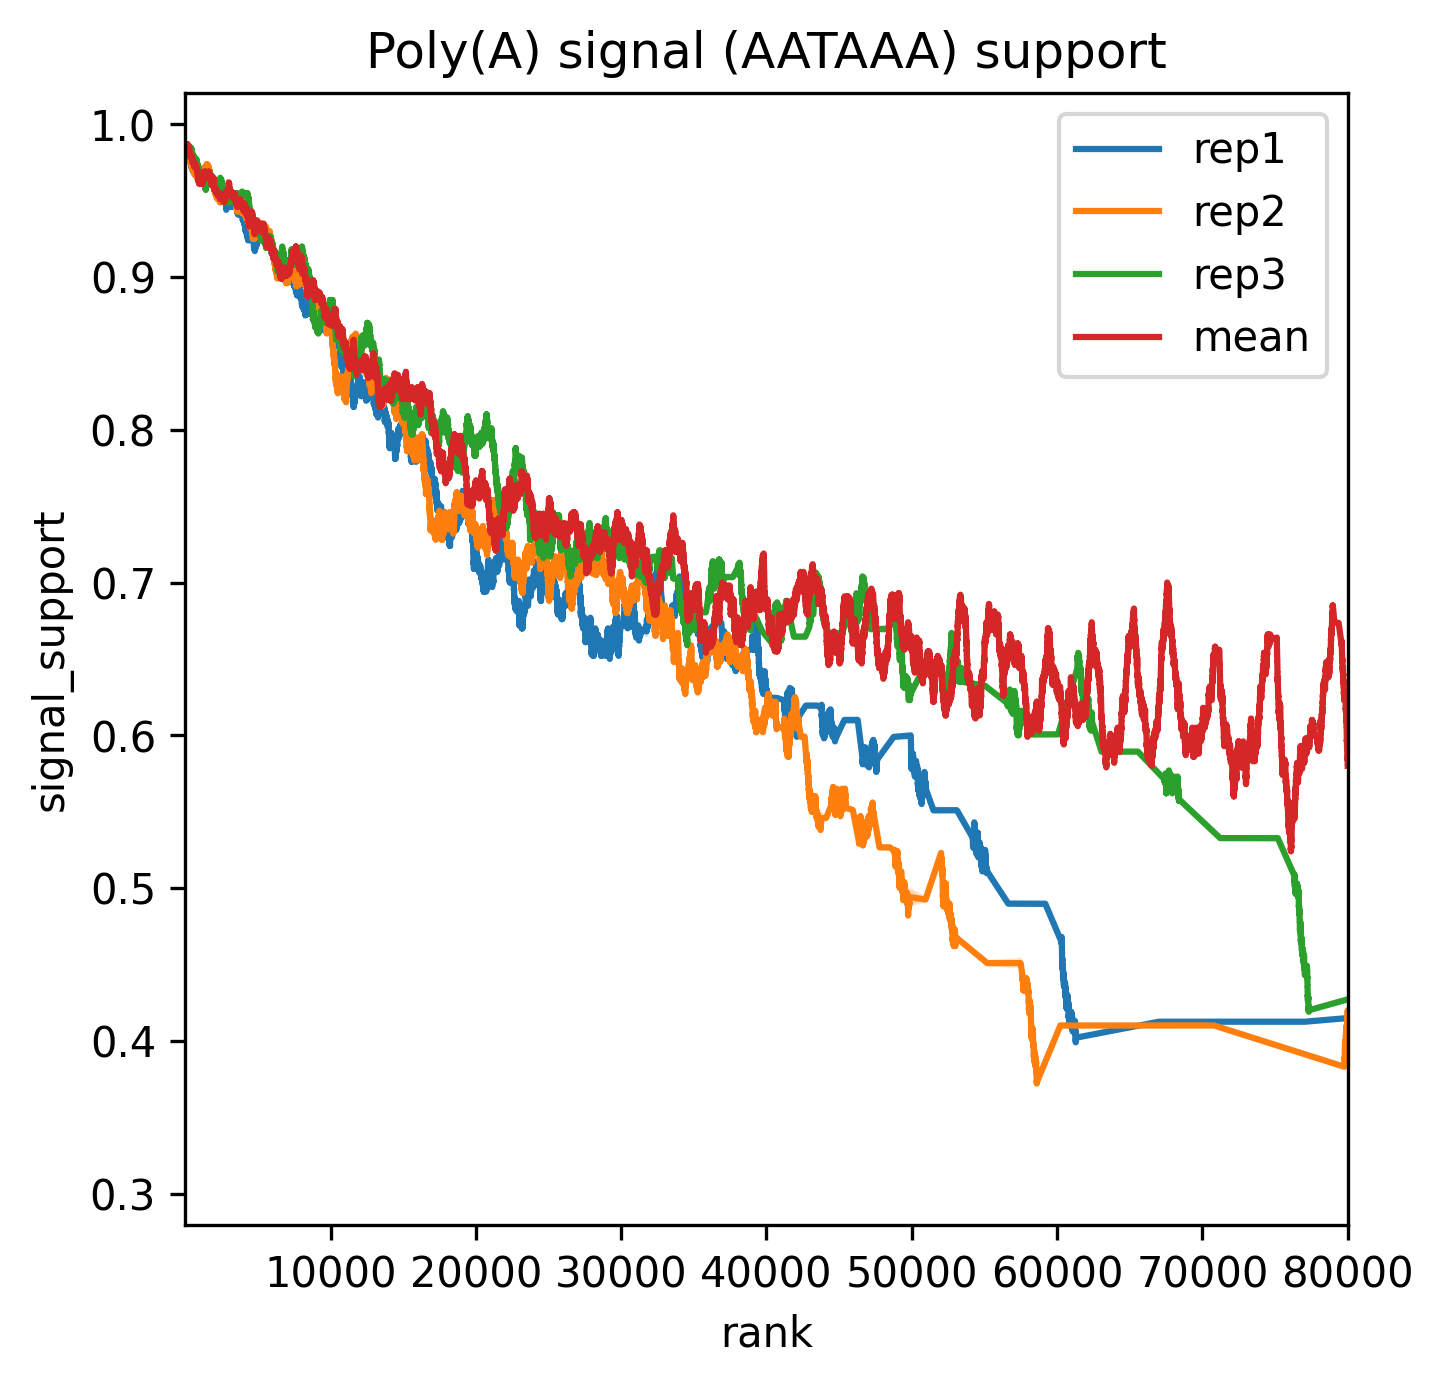

In [5]:
plt.figure(figsize=(5, 5), dpi=300)

for _df in polya_atlas:
    _df = _df.copy()
    _df['signal_support'] = ~_df.signal.isna()
    _df = _df[['signal_support', 'tpm']].sort_values('tpm').rolling(1000).mean()
    _df['rank'] = _df['tpm'].rank(ascending=False)
    sns.lineplot(data=_df, x='rank', y='signal_support')

_df = polya_atlas[0].copy()
_df['signal_support'] = ~_df.signal.isna()
_df = _df[['signal_support', 'tpm_ave']].sort_values('tpm_ave').rolling(1000).mean()
_df['rank'] = _df['tpm_ave'].rank(ascending=False)
sns.lineplot(data=_df, x='rank', y='signal_support')

plt.xlim((1, 80000))
plt.title('Poly(A) signal (AATAAA) support')
plt.legend(['rep1', 'rep2', 'rep3', 'mean'])

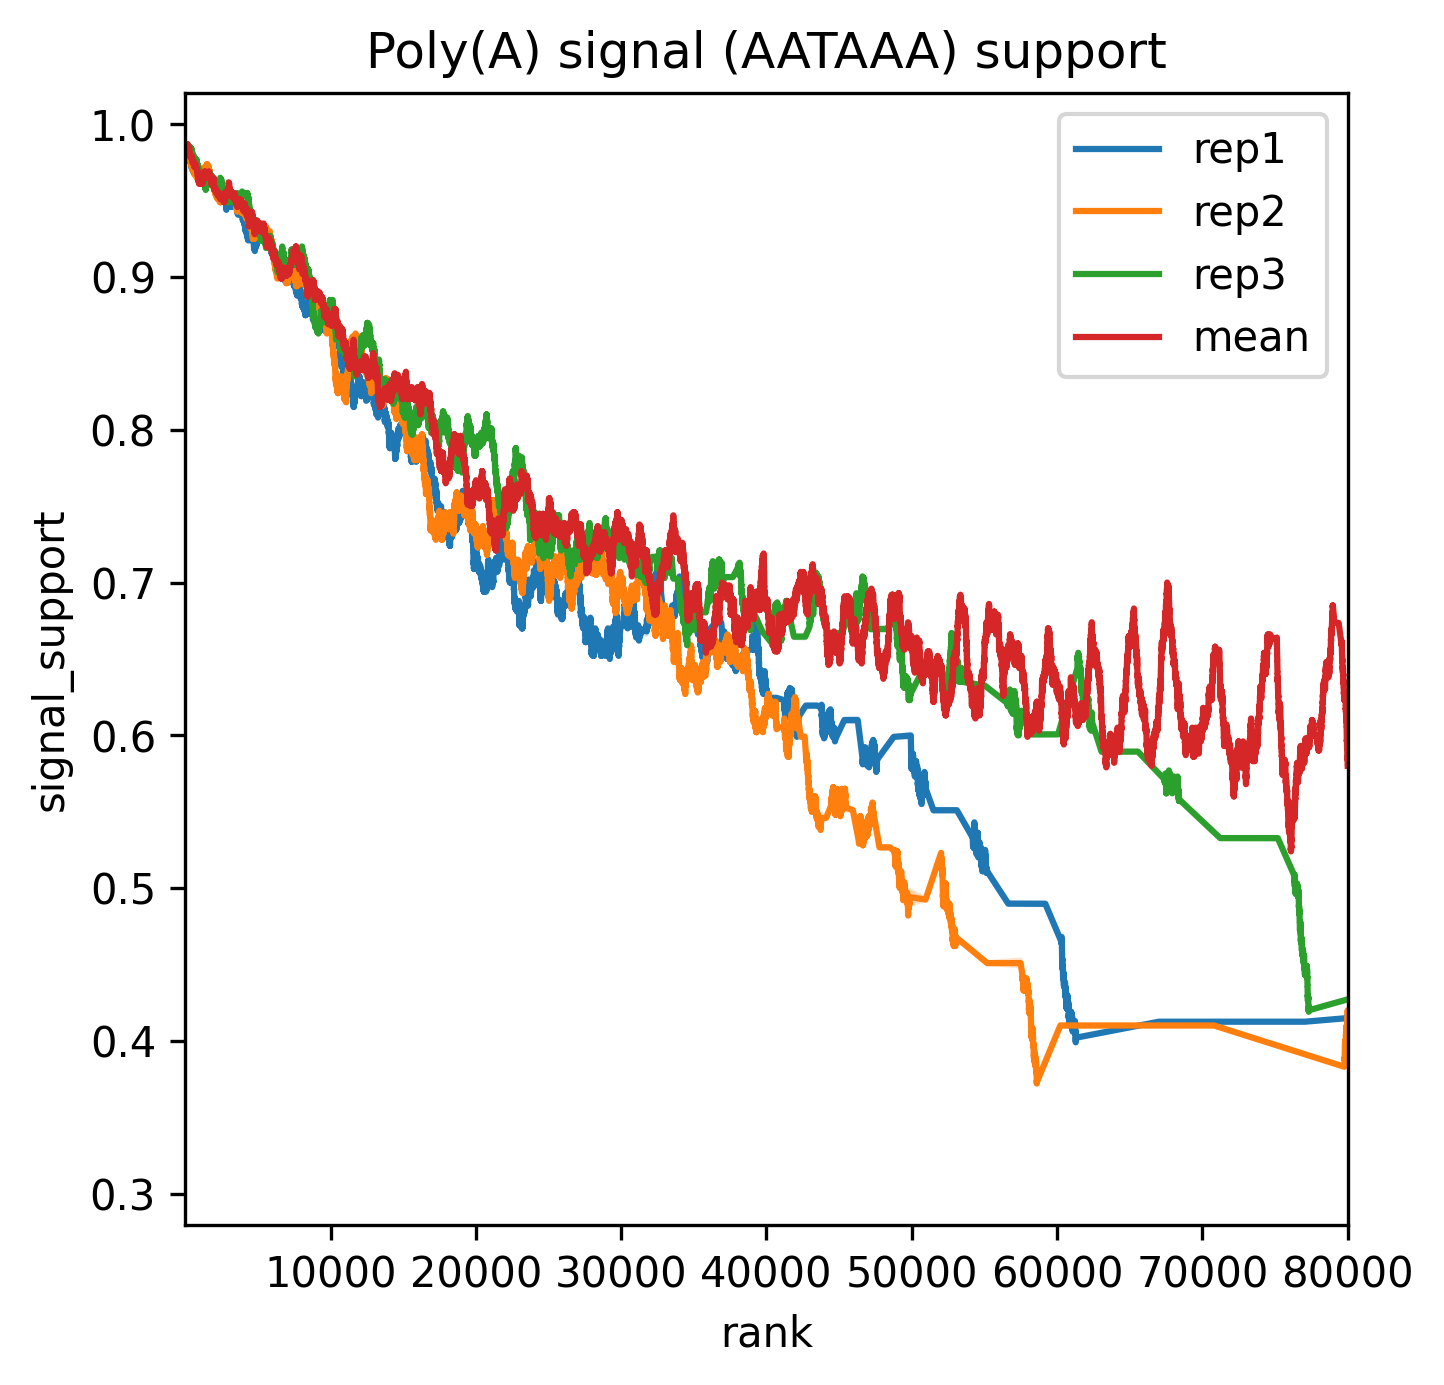

In [12]:
plt.figure(figsize=(5, 5), dpi=300)

for _df in polya_atlas:
    _df = _df.copy()
    _df['signal_support'] = ~_df.signal.isna()
    _df = _df[['signal_support', 'tpm']].sort_values('tpm').rolling(1000).mean()
    _df['rank'] = _df['tpm'].rank(ascending=False)
    sns.lineplot(data=_df, x='rank', y='signal_support')

_df = polya_atlas[0].copy()
_df['signal_support'] = ~_df.signal.isna()
_df = _df[['signal_support', 'tpm_ave']].sort_values('tpm_ave').rolling(1000).mean()
_df['rank'] = _df['tpm_ave'].rank(ascending=False)
sns.lineplot(data=_df, x='rank', y='signal_support')

plt.xlim((1, 80000))
plt.title('Poly(A) signal (AATAAA) support')
plt.legend(['rep1', 'rep2', 'rep3', 'mean'])

In [13]:
df_rep = pd.concat([
    df[['tpm']].rename(columns={'tpm': f'tpm_{i}'})
    for i, df in enumerate(polya_atlas)
], axis=1)

df_rep['tpm_ave'] = df_rep.mean(axis=1)
df_rep['replication'] = (df_rep[['tpm_0', 'tpm_1', 'tpm_2']] > 0).sum(axis=1)

Text(0, 0.5, 'Replication moving average')

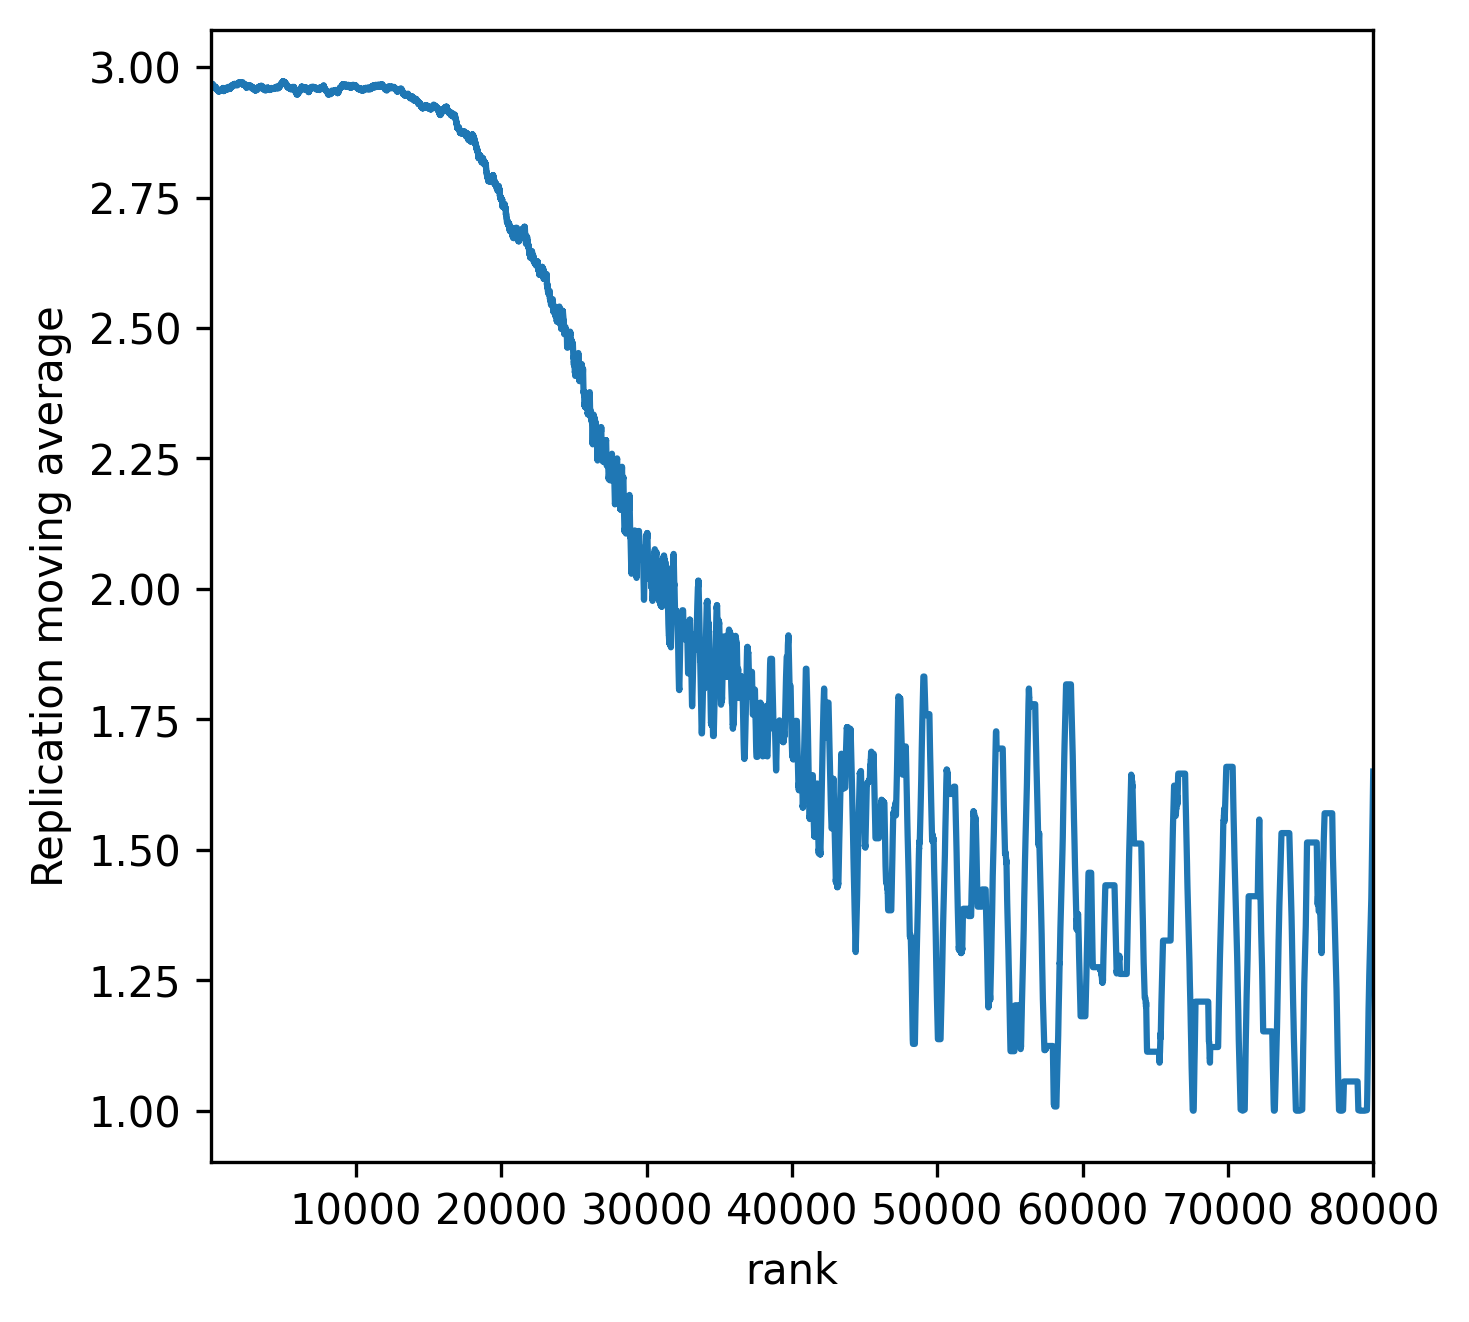

In [14]:
plt.figure(figsize=(5, 5), dpi=300)
_df = df_rep[['replication', 'tpm_ave']].sort_values('tpm_ave').rolling(1000).mean()
_df['rank'] = _df['tpm_ave'].rank(ascending=False)
sns.lineplot(data=_df, x='rank', y='replication')
plt.xlim((1, 80000))
plt.ylabel('Replication moving average')

In [3]:
from lapa.result import LapaResult

In [4]:
result_tail = LapaResult(snakemake.input['lapa_tail'])

In [5]:
result_end = LapaResult(snakemake.input['lapa_end'])

In [6]:
df_tail = result_tail.read_cluster()
df_end = result_end.read_cluster()

Text(0.5, 1.0, 'Poly(A) signal (AATAAA) support')

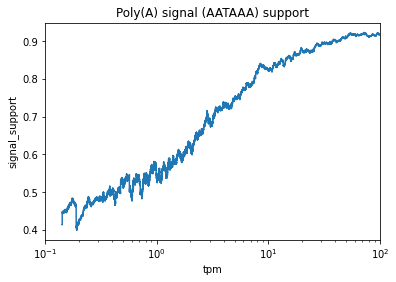

In [17]:
_df = df_tail.copy()
_df['signal_support'] = _df['signal'] != 'None@None'
_df = _df[['signal_support', 'tpm']].sort_values('tpm').rolling(1000).mean()

sns.lineplot(data=_df, x='tpm', y='signal_support')

plt.xscale('log')
plt.xlim((0.1, 100))
plt.title('Poly(A) signal (AATAAA) support')

In [36]:
_df = df_end.copy()
_df['signal_support'] = _df['signal'] != 'None@None'
_df = _df.sort_values('count') = _df.sort_values('count')

In [42]:
_df['signal_support'] = _df['signal_support'].rolling(1000).mean()

In [ ]:
_df['rank'] = _df['count'].rank(ascending=False)
sns.lineplot(data=_df, x='count', y='signal_support')
plt.xlim((1, 80000))

Text(0.5, 1.0, 'Poly(A) signal (AATAAA) support')

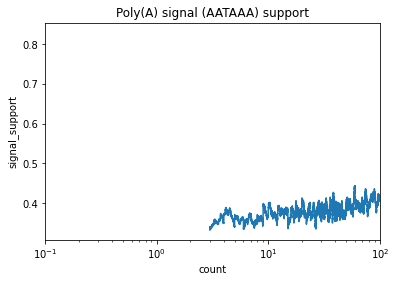

In [32]:
_df = df_end.copy()
_df['signal_support'] = _df['signal'] != 'None@None'
_df = _df[['signal_support', 'count']].sort_values('count').rolling(1000).mean()

sns.lineplot(data=_df, x='count', y='signal_support')

plt.xscale('log')
plt.xlim((0.1, 100))
plt.title('Poly(A) signal (AATAAA) support')

(1.0, 80000.0)

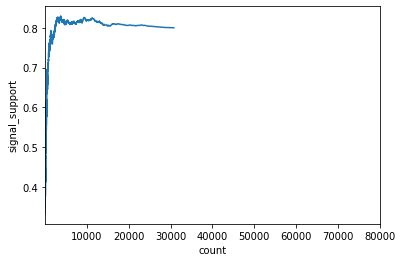

In [33]:
_df['rank'] = _df['count'].rank(ascending=False)
sns.lineplot(data=_df, x='count', y='signal_support')
plt.xlim((1, 80000))

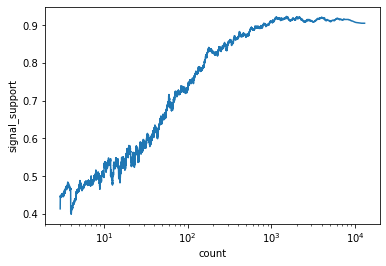

In [23]:
_df = df_tail.copy()
_df['signal_support'] = _df['signal'] != 'None@None'
_df = _df[['signal_support', 'count']].sort_values('count').rolling(1000).mean()

sns.lineplot(data=_df, x='count', y='signal_support')

plt.xscale('log')

(1.0, 80000.0)

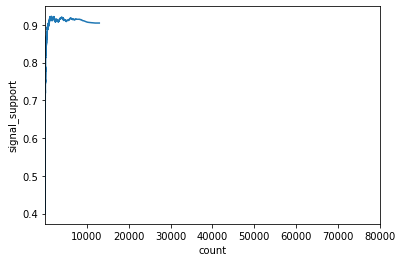

In [28]:
_df['rank'] = _df['count'].rank(ascending=False)
sns.lineplot(data=_df, x='count', y='signal_support')
plt.xlim((1, 80000))

In [29]:
_df

,signal_support,count,rank
31838,NaN,NaN,NaN
60947,NaN,NaN,NaN
5496,NaN,NaN,NaN
22266,NaN,NaN,NaN
60964,NaN,NaN,NaN
...,...,...,...
43,0.908,9917.893,5.0
69,0.907,10250.371,4.0
27484,0.906,11004.370,3.0
64451,0.905,11992.583,2.0
